     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59056 sha256=e7a6c301c69f1a7ed1244648314bec6d1f690cf0df1f862e021c94abfaf48a95
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit


<ipython-input-1-6fd5ca6ea0cf>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AUSPICE', y='value', data=df_melt, palette="Set3")


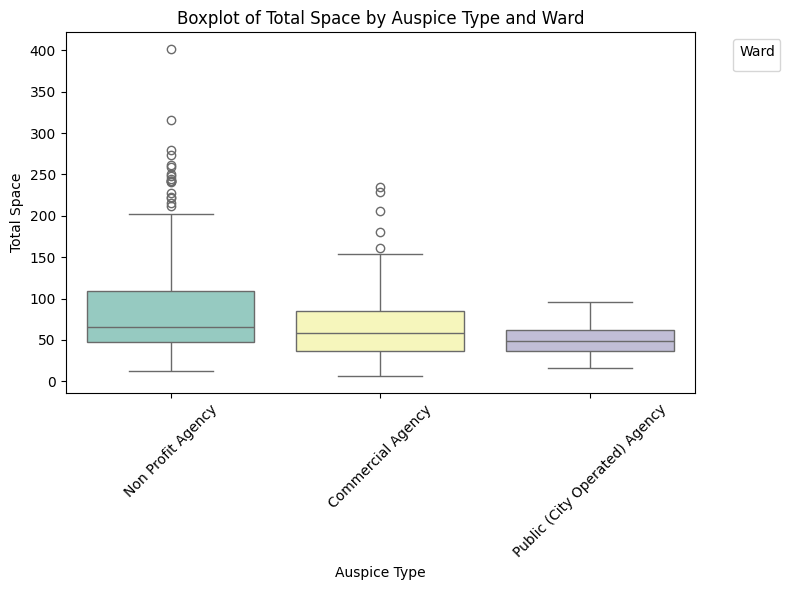

In [1]:
!pip install bioinfokit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
from scipy import stats

# Load dataset
df = pd.read_excel("INF2178_A2_data.xlsx")

df_melt = pd.melt(df, id_vars=['AUSPICE', 'bldg_type'], value_vars=['TOTSPACE'])
df_melt['bldg_type'] = df_melt['bldg_type'].astype('category')


# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='AUSPICE', y='value', data=df_melt, palette="Set3")
plt.title('Boxplot of Total Space by Auspice Type and Ward')
plt.ylabel('Total Space')
plt.xlabel('Auspice Type')
plt.xticks(rotation=45)
plt.legend(title='Ward', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

In [ ]:
# Perform the ANOVA using statsmodels
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),2.0,9.611211e+04,48056.057145,21.843051,5.057716e-10
Residual,1060.0,2.332065e+06,2200.061571,NaN,NaN


In [ ]:
# perform Tukey's HSD post hoc test using bioinfokit
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
tukey_summary = res.tukey_summary
tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,17.119417,9.703599,24.535235,7.662434,0.001000
1,Non Profit Agency,Public (City Operated) Agency,34.334610,16.224077,52.445142,6.292710,0.001000
2,Commercial Agency,Public (City Operated) Agency,17.215193,-1.453146,35.883531,3.060857,0.077966


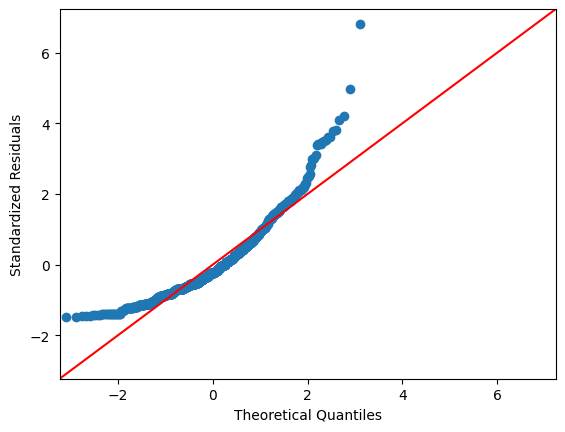

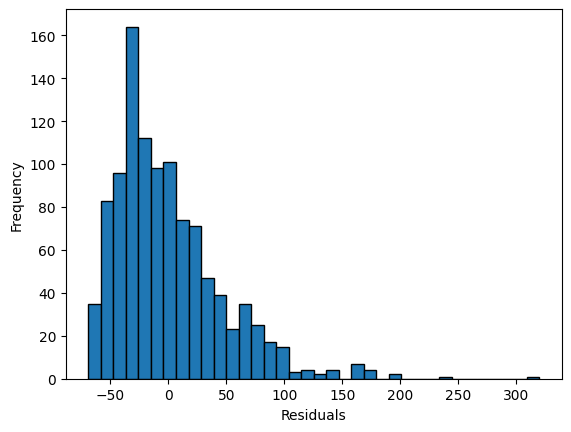

In [ ]:
# Q-Q plot
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# Histogram of residuals
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Perform the Shapiro-Wilk test on the residuals of the model to assess normality
w, pvalue = stats.shapiro(model.resid)
print(f"Shapiro-Wilk test statistic: {w}, p-value: {pvalue}")

if pvalue > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

Shapiro-Wilk test statistic: 0.901775598526001, p-value: 1.4964898448030214e-25
Residuals are not normally distributed.


In [ ]:
# Perform Bartlett's test to check for homogeneity of variances across groups.
grouped_data = df_melt.groupby('treatments')['value'].apply(list).values
w, pvalue = stats.bartlett(*grouped_data)
print(f"Bartlett's test statistic: {w}, p-value: {pvalue}")

res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

Bartlett's test statistic: 89.58603867335393, p-value: 3.520779884632816e-20


,Parameter,Value
0,Test statistics (T),89.586
1,Degrees of freedom (Df),2.000
2,p value,0.000


In [ ]:
# Perform Levene's test for homogeneity of variances using the 'stat' object/function
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary

,Parameter,Value
0,Test statistics (W),17.9271
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


In [ ]:
# Perform 2-WAY ANOVA test
df['ward'] = df['ward'].astype(str)
model = ols('TOTSPACE ~ C(AUSPICE) + C(ward) + C(AUSPICE):C(ward)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 19
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(AUSPICE),8.539351e+04,2.0,19.485149,5.004717e-09
C(ward),8.898212e+04,24.0,1.692000,3.200458e-02
C(AUSPICE):C(ward),8.288887e+04,48.0,0.788068,8.317984e-01
Residual,2.178098e+06,994.0,NaN,NaN


In [ ]:
df_melt = pd.melt(df, id_vars=['AUSPICE', 'ward'], value_vars=['TOTSPACE'])
df_melt.columns = ['AUSPICE', 'Ward', 'Variable', 'TOTSPACE']
df_melt.head()

,AUSPICE,Ward,Variable,TOTSPACE
0,Non Profit Agency,3,TOTSPACE,164
1,Non Profit Agency,8,TOTSPACE,83
2,Non Profit Agency,25,TOTSPACE,102
3,Non Profit Agency,10,TOTSPACE,65
4,Non Profit Agency,20,TOTSPACE,26


In [ ]:
# Build an ordinary least squares (OLS) model to assess the impact of 'AUSPICE' and 'ward'
model = ols('TOTSPACE ~ C(AUSPICE) + C(ward) + C(AUSPICE):C(ward)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 19
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(AUSPICE),8.539351e+04,2.0,19.485149,5.004717e-09
C(ward),8.898212e+04,24.0,1.692000,3.200458e-02
C(AUSPICE):C(ward),8.288887e+04,48.0,0.788068,8.317984e-01
Residual,2.178098e+06,994.0,NaN,NaN


In [ ]:
# Perform ANOVA using the 'anova_stat' method of the 'stat' object
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(AUSPICE) + C(ward) + C(AUSPICE):C(ward)')
res.anova_summary

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 18
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,9.914924e+04,49574.619836,22.623942,2.463860e-10
C(ward),24.0,9.083235e+04,3784.681369,1.727182,2.989186e-02
C(AUSPICE):C(ward),48.0,8.288887e+04,1726.851486,0.788068,8.317984e-01
Residual,994.0,2.178098e+06,2191.245882,NaN,NaN


<ipython-input-8-e35f4dddaec9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['bldg_type'] = df_filtered['bldg_type'].astype('category')


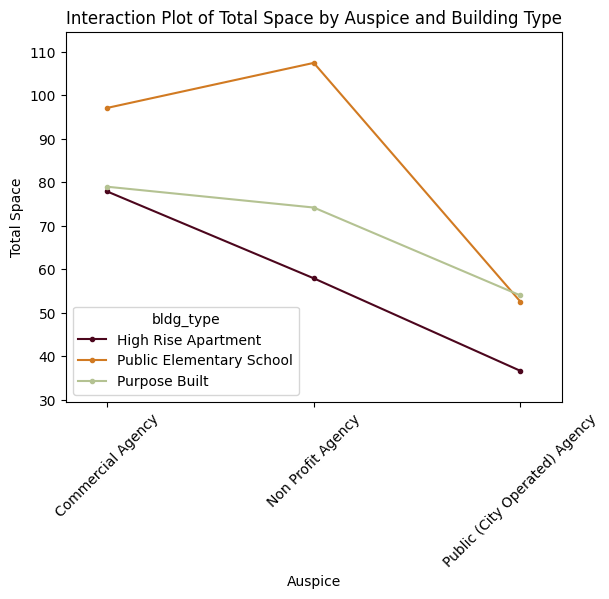

In [ ]:
from statsmodels.graphics.factorplots import interaction_plot

# Filter the DataFrame to include only the categories of interest
df_filtered = df[df['bldg_type'].isin(['Public Elementary School', 'High Rise Apartment', 'Purpose Built'])]

# Ensure 'bldg_type' is treated as a categorical variable:
df_filtered['bldg_type'] = df_filtered['bldg_type'].astype('category')

# Generate the interaction plot for the filtered DataFrame
fig = interaction_plot(x=df_filtered['AUSPICE'], trace=df_filtered['bldg_type'], response=df_filtered['TOTSPACE'],
                       colors=['#4c061d','#d17a22','#b4c292'])

plt.title('Interaction Plot of Total Space by Auspice and Building Type')
plt.xlabel('Auspice')
plt.ylabel('Total Space')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Perform the Tukey HSD (Honestly Significant Difference) post-hoc test using the 'tukey_hsd' method.
res = stat()
res.tukey_hsd(df=df_filtered, res_var='TOTSPACE', xfac_var='bldg_type', anova_model='TOTSPACE ~ C(bldg_type)')
tukey_summary = res.tukey_summary
tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Public Elementary School,High Rise Apartment,29.797065,-10.414011,70.008142,2.467226,0.190403
1,Public Elementary School,Purpose Built,37.005399,8.031949,65.978849,4.252517,0.007970
2,High Rise Apartment,Purpose Built,7.208333,-41.086693,55.503360,0.496951,0.900000
